In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
import os
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
import shutil
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import random
import pickle

In [ ]:
# Loading the whole data

start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from data_folder/combined_data_1.txt...
Done.

Reading ratings from data_folder/combined_data_2.txt...
Done.

Reading ratings from data_folder/combined_data_3.txt...
Done.

Reading ratings from data_folder/combined_data_4.txt...
Done.

Time taken : 0:05:03.705966


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


In [ ]:
# Checking if there are any null values in the Dataset.
sum(df.isnull().any())

0

In [ ]:
# Distribution of number of rating 
df.rating.value_counts()

4    33750958
3    28811247
5    23168232
2    10132080
1     4617990
Name: rating, dtype: int64

In [ ]:
# Storing this CSV as Parquet file as it is more optimized in storage.

df = pd.read_csv("data.csv",names=['movie', 'user','rating','date'])
df.sort_values(by="date",inplace=True)

df.to_parquet("/content/drive/MyDrive/netflix_assignment/")
del df

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/netflix_assignment/data.parquet")

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/netflix_assignment/train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("/content/drive/MyDrive/netflix_assignment/train.csv", index=False)

if not os.path.isfile('/content/drive/MyDrive/netflix_assignment/test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("/content/drive/MyDrive/netflix_assignment/test.csv", index=False)

train_df = pd.read_csv("/content/drive/MyDrive/netflix_assignment/train.csv", parse_dates=['date'])
test_df = pd.read_csv("/content/drive/MyDrive/netflix_assignment/test.csv")

In [ ]:
# Columns in the data.
df.columns

Index(['movie', 'user', 'rating', 'date'], dtype='object')

In [ ]:
print("Number of Unique Movies are",len(np.unique(df["movie"])))

Number of Unique Movies are 17770


In [ ]:
print("Number of Unique users are",len(np.unique(df["user"])))

Number of Unique users are 480189


# Splitting the data into train and test

In [ ]:
start = datetime.now()
if os.path.isfile('/content/drive/MyDrive/netflix_assignment/train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    train_sparse_matrix = sparse.load_npz('/content/drive/MyDrive/netflix_assignment/train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("/content/drive/MyDrive/netflix_assignment/train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:05.056241


In [ ]:
start = datetime.now()
if os.path.isfile('/content/drive/MyDrive/netflix_assignment/test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    test_sparse_matrix = sparse.load_npz('/content/drive/MyDrive/netflix_assignment/test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("/content/drive/MyDrive/netflix_assignment/test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:01.777971


In [ ]:
# Loading Movie CSV file.
movie_df = pd.read_csv("/content/drive/MyDrive/netflix_assignment/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'],index_col = 'movie_id', encoding = "ISO-8859-1")

In [ ]:
movie_counter = Counter(df.movie.values)

if not os.path.isfile("/content/drive/MyDrive/netflix_assignment/sorted_movies.pickle"):
  sorted_movies = np.array(sorted(movie_counter.items(),key=lambda k:(k[1],k[0]),reverse=True))
  with open('/content/drive/MyDrive/netflix_assignment/sorted_movies.pickle', 'wb') as handle:
      pickle.dump(sorted_movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
  with open("/content/drive/MyDrive/netflix_assignment/sorted_movies.pickle", 'rb') as handle:
    sorted_movies = pickle.load(handle)

In [ ]:
df.loc[sorted_movies[:10]]

,movie,user,rating,date
5317,8,2636538,2,2005-05-04
15124,8,1753777,5,2005-03-26
14313,8,2585195,2,2005-11-24
15205,8,1400154,4,2005-07-12
1905,3,594683,5,2004-05-14
6287,8,2327422,2,2005-05-04
11283,8,593949,1,2005-05-08
16377,8,106217,3,2005-10-03
16242,8,579100,2,2005-07-20
12470,8,946179,5,2005-03-23


**Calculating Movie-Movie Similariy**

In [ ]:
# I am creating sparse matrix of size 480189*17770. As many values are zeros so we are using Sparse matrix representation.

sparse_matrix = sparse.csr_matrix((df.rating.values, (df.user.values,df.movie.values)),)

# Here I am calculating mean rating of every movie and saved it in new CSV file.
movie_rating_dict = {}

sum_list = sparse_matrix.sum(axis=0).A[0]
movie_counter = Counter(df.movie.values)

for i in range(1,sparse_matrix.shape[1]):
  movie_rating_dict[i] = sum_list[i]/movie_counter[i]

movie_df["Rating"] = list(movie_rating_dict.values())
movie_df.to_csv("/content/drive/MyDrive/netflix_assignment/Movies.csv")

In [ ]:
movie_df = pd.read_csv("/content/drive/MyDrive/netflix_assignment/Movies.csv",index_col=["movie_id"])
movie_df.head()

,year_of_release,title,Rating
movie_id,,,
1,2003.0,Dinosaur Planet,3.749543
2,2004.0,Isle of Man TT 2004 Review,3.558621
3,1997.0,Character,3.641153
4,1994.0,Paula Abdul's Get Up & Dance,2.739437
5,2004.0,The Rise and Fall of ECW,3.919298


In [ ]:
if not os.path.isfile("/content/drive/MyDrive/netflix_assignment/m_m_sim_matrix.npz"):
  m_m_sim_sparse = cosine_similarity(X=sparse_matrix.T, dense_output=False)
  scipy.sparse.save_npz("/content/drive/MyDrive/netflix_assignment/m_m_sim_matrix.npz",m_m_sim_sparse)
else:
  m_m_sim_sparse = scipy.sparse.load_npz("/content/drive/MyDrive/netflix_assignment/m_m_sim_matrix.npz")

In [ ]:
movie_idx_dict = {}   # Mapping of movie name to movie id
idx_movie_dict = {}   # Mapping of movie id to movie name

for idx,row in movie_df.iterrows():
  movie_idx_dict[row["title"]] = idx
  idx_movie_dict[idx] = row["title"]

In [ ]:
if not os.path.isfile("/content/drive/MyDrive/netflix_assignment/similar_movies.pickle"):
  # Storing top 50 similar movies based on cosine simialrity for every movie.
  similar_movies = {}

  for i in range(1,m_m_sim_sparse.shape[0]):
    similar_movies[i] = m_m_sim_sparse[i].toarray()[0].argsort()[::-1][1:50]
  with open('/content/drive/MyDrive/netflix_assignment/similar_movies.pickle', 'wb') as handle:
      pickle.dump(similar_movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
  with open("/content/drive/MyDrive/netflix_assignment/similar_movies.pickle", 'rb') as handle:
    similar_movies = pickle.load(handle)

In [ ]:
# Testing if movie-movie based reccomendation is working or not
i = 67
print(movie_df.loc[i]["title"])
print("Reccomended Movies")
list(movie_df.loc[similar_movies[i][:20]]["title"])

Vampire Journals
Reccomended Movies


['Modern Vampires',
 'Subspecies 4: Bloodstorm',
 'To Sleep With a Vampire',
 'Dracula: The Dark Prince',
 'Dracula Rising',
 'Vampires: Los Muertos',
 'Vampirella',
 'Club Vampire',
 'The Breed',
 'Dracula II: Ascension',
 'Scars of Dracula',
 'Kindred: The Embraced: The Complete Vampire Collection',
 'Innocent Blood',
 'She Creature',
 'Blood Moon',
 'Earth vs. The Spider',
 'Captain Kronos: Vampire Hunter',
 'Reign in Darkness',
 'The Locals',
 'The Shiver of the Vampires']

**Calculating User-User similarities.**

In [ ]:
def get_average_ratings(sparse_matrix, of_users):
  ax = 1 if of_users else 0  # 1 - User axes,0 - Movie axes
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  is_rated = sparse_matrix!=0

  # no of ratings that each user OR movie..
  no_of_ratings = is_rated.sum(axis=ax).A1
  u,m = sparse_matrix.shape
  # creae a dictonary of users and their average ratigns..
  average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] !=0 }
  # return that dictionary of average ratings
  return average_ratings

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    return sample_sparse_matrix

In [ ]:
start = datetime.now()
path = "/content/drive/MyDrive/netflix_assignment/sample_train_sparse_matrix.npz"

if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.215923


In [ ]:
start = datetime.now()
path = "/content/drive/MyDrive/netflix_assignment/sample_test_sparse_matrix.npz"

if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.195653


In [ ]:
# get the global average of ratings in our train set.
sample_train_averages = dict()
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

In [ ]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('Average rating of user 1515220 :',sample_train_averages['user'][1515220])

Average rating of user 1515220 : 3.9655172413793105


In [ ]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('Average rating of movie 15153 :',sample_train_averages['movie'][15153])

Average rating of movie 15153 : 2.6458333333333335


In [ ]:
print('No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 129286

No of ratings in Our Sampled test  matrix is : 7333



In [ ]:
start = datetime.now()

# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

if os.path.isfile('/content/drive/MyDrive/netflix_assignment/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('/content/drive/MyDrive/netflix_assignment/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:20] 
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            #--------------------- Ratings by "user" to similar movies of "movie" ---------------------

            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:20] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.019317


In [ ]:
reg_train = pd.read_csv('/content/drive/MyDrive/netflix_assignment/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


In [ ]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [ ]:
total_users = np.unique(np.concatenate((sample_test_users,sample_train_users)))
total_movies = np.unique(np.concatenate((sample_test_movies,sample_train_movies)))

In [ ]:
import csv 
if not os.path.isfile('/content/drive/MyDrive/netflix_assignment/sample_movies.csv'):
  with open('/content/drive/MyDrive/netflix_assignment/sample_movies.csv', mode='w') as data_file:
      data_file.write("Movie_id")
      data_file.write('\n')
      for movie_id in total_movies:
        data_file.write(str(movie_id))
        data_file.write('\n')
if not os.path.isfile('/content/drive/MyDrive/netflix_assignment/sample_users.csv'):
  with open('/content/drive/MyDrive/netflix_assignment/sample_users.csv', mode='w') as data_file:
      data_file.write("User_id")
      data_file.write('\n')
      for user_id in total_users:
        data_file.write(str(user_id))
        data_file.write('\n')

In [ ]:
import pandas as pd
import numpy as np
movie_list = pd.read_csv('/content/drive/MyDrive/netflix_assignment/sample_movies.csv')
movie_list = np.array(movie_list.iloc[:,0])

In [ ]:
start = datetime.now()

if os.path.isfile('/content/drive/MyDrive/netflix_assignment/reg_test.csv'):
    print("It is already created...")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('/content/drive/MyDrive/netflix_assignment/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            try:   
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:20] 
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                # Cold STart Problem #
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try: 
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])

            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])

            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [ ]:
reg_test_df = pd.read_csv('/content/drive/MyDrive/netflix_assignment/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619431 sha256=9ad0df792ea281cc2d7c1596548be3cc7f969c281a6effbd266ec7cfb7785a5e
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))

In [ ]:
models_evaluation_train = dict()
models_evaluation_test = dict()

In [ ]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test,verbose=True):
    train_results = dict()
    test_results = dict()

    # fit the model
    print('Training the model..')
    start = datetime.now()
    algo.fit(x_train, y_train)
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}

    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

In [ ]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    return actual, pred


def get_errors(predictions, print_them=False):
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)
    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True): 
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

Training the model..
Done. Time taken : 0:00:06.069747

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.076373581778953
MAPE :  34.48223172520999


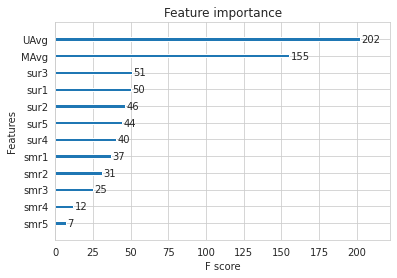

In [ ]:
import xgboost as xgb
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15, n_estimators=100,objective='reg:squarederror')
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test,verbose= True)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

In [ ]:
test_results

{'mape': 34.48223172520999,
 'predictions': array([3.503703, 3.503703, 3.503703, ..., 3.503703, 3.503703, 3.503703],
       dtype=float32),
 'rmse': 1.076373581778953}

In [ ]:
from surprise import BaselineOnly 

bsl_options = {'method': 'sgd',
               'learning_rate': 0.001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:01.465096 

Evaluating the model with train data..
time taken : 0:00:01.404590
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.078704
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.949306


In [ ]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

In [ ]:
reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679


In [ ]:
from surprise import SVD

svd = SVD(n_factors=100, biased=True, random_state=15)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Done. time taken : 0:00:08.253656 

Evaluating the model with train data..
time taken : 0:00:01.664260
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660474

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.073838
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.996648


In [ ]:
from surprise import SVDpp
svdpp = SVDpp(n_factors=50, random_state=15)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
Done. time taken : 0:02:07.676461 

Evaluating the model with train data..
time taken : 0:00:10.138279
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.285279
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:18.107174


In [ ]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

In [ ]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.278967,3.538247
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708,3.385723,2.879361
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411,2.944656,3.091422
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637,3.456119,3.394619


In [ ]:
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

xgb_final = xgb.XGBRegressor(n_jobs=-1, random_state=15,objective='reg:squarederror')
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

In [ ]:
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

xgb_final = xgb.XGBRegressor(n_jobs=-1, random_state=15,objective='reg:squarederror')
xgb_final.fit(x_train, y_train, eval_metric = 'rmse')


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=15, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(100,max_depth=3,n_jobs=-1)
train_results, test_results = run_xgboost(clf, x_train, y_train, x_test, y_test,verbose= True)

Training the model..
Done. Time taken : 0:00:19.261492

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1017859728708188
MAPE :  33.35203338798235


In [ ]:
y_train_pred = clf.predict(x_train)

In [ ]:
# Saving all 4 models

filename = '/content/drive/MyDrive/netflix_assignment/baseline_model.sav'
pickle.dump(bsl_algo, open(filename, 'wb'))

filename = '/content/drive/MyDrive/netflix_assignment/svd_model.sav'
pickle.dump(svd, open(filename, 'wb'))

filename = '/content/drive/MyDrive/netflix_assignment/svdpp_model.sav'
pickle.dump(svdpp, open(filename, 'wb'))

filename = '/content/drive/MyDrive/netflix_assignment/xgb_model.sav'
pickle.dump(xgb_final, open(filename, 'wb'))

filename = '/content/drive/MyDrive/netflix_assignment/random_forest_model.sav'
pickle.dump(clf, open(filename, 'wb'))